# **Forecasting Exchange Rates using Time Series Analysis**

## **Part 1: Data Preparation and Exploration**

**1. Data Loading**

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
df = pd.read_csv('/content/exchange_rate.csv')
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


**2. Initial Exploration**

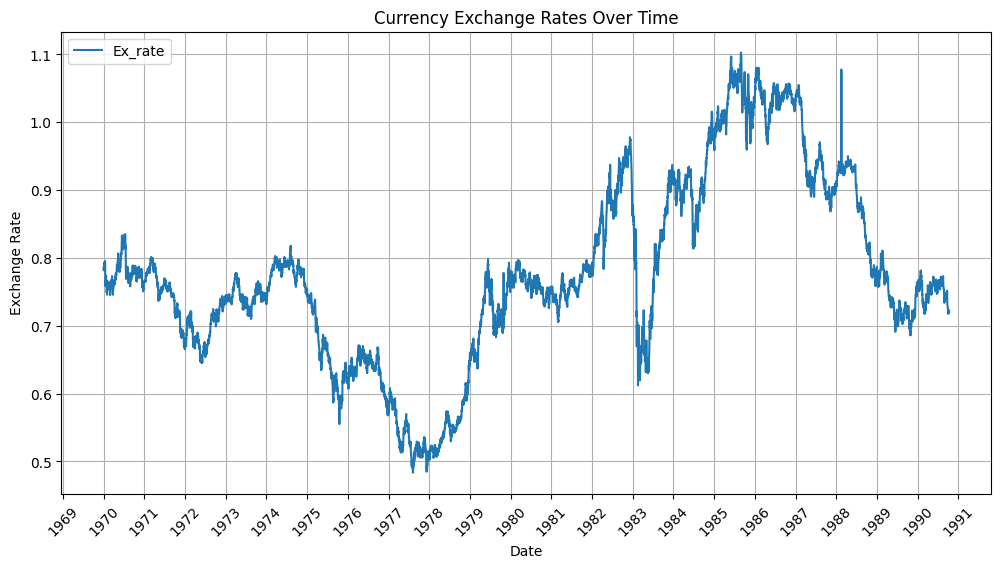

In [53]:
import matplotlib.dates as mdates

# Plotting time series for each currency to observe trends and anomalies
plt.figure(figsize=(12, 6))
for column in df.columns[1:]:  # Ignoring the 'Date' column
    plt.plot(df['date'], df[column], label=column)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Currency Exchange Rates Over Time')
plt.legend(loc='upper left')

# Setting major ticks every year and formatting the x-axis to show only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Only display year

# Rotating x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

**3. Data Preprocessing**

In [54]:
# Checking for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 date       0
Ex_rate    0
dtype: int64


In [55]:
# Imputing missing values if any exist
# Here we will use forward fill to handle missing values based on time series continuity
df.fillna(method='ffill', inplace=True)

<ipython-input-55-a7ea3d6d659f>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [56]:
# Verifying that there are no missing values left
print("Missing values after preprocessing:\n", df.isnull().sum())

Missing values after preprocessing:
 date       0
Ex_rate    0
dtype: int64


## **Part 2: Model Building - ARIMA**

**1. Parameter Selection for ARIMA: ACF and PACF Plots**

In [57]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [58]:
# Selecting a single currency time series for analysis (e.g., 'Ex_rate')
exchange_rate = df['Ex_rate']

In [59]:
# Plotting ACF and PACF to estimate p and q
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'ACF Plot')

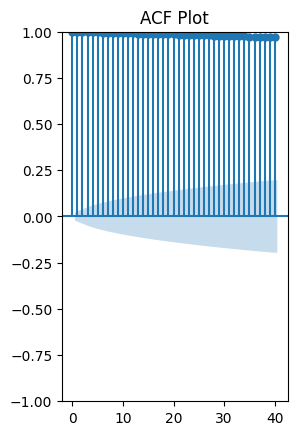

In [60]:
# ACF plot for identifying q (MA order)
plt.subplot(121)
plot_acf(exchange_rate, ax=plt.gca(), lags=40)
plt.title('ACF Plot')

Text(0.5, 1.0, 'PACF Plot')

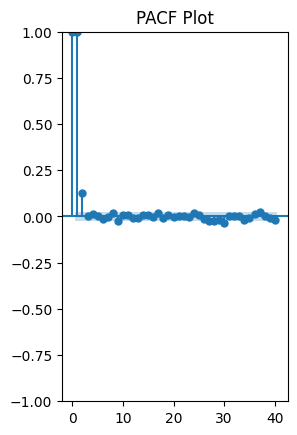

In [61]:
# PACF plot for identifying p (AR order)
plt.subplot(122)
plot_pacf(exchange_rate, ax=plt.gca(), lags=40)
plt.title('PACF Plot')

**2. Model Fitting: ARIMA**

In [62]:
# Importing the ARIMA model
from statsmodels.tsa.arima.model import ARIMA

In [63]:
# Defining the ARIMA model with estimated parameters (p=1, d=1, q=1)
model = ARIMA(exchange_rate, order=(1, 1, 1))

In [64]:
# Fitting the model
arima_model = model.fit()

In [65]:
# Summary of the model
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sat, 05 Oct 2024   AIC                         -56102.322
Time:                        15:28:38   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

**3. Diagnostics: Residual Analysis**

In [66]:
# Importing necessary libraries for diagnostics
import statsmodels.api as sm

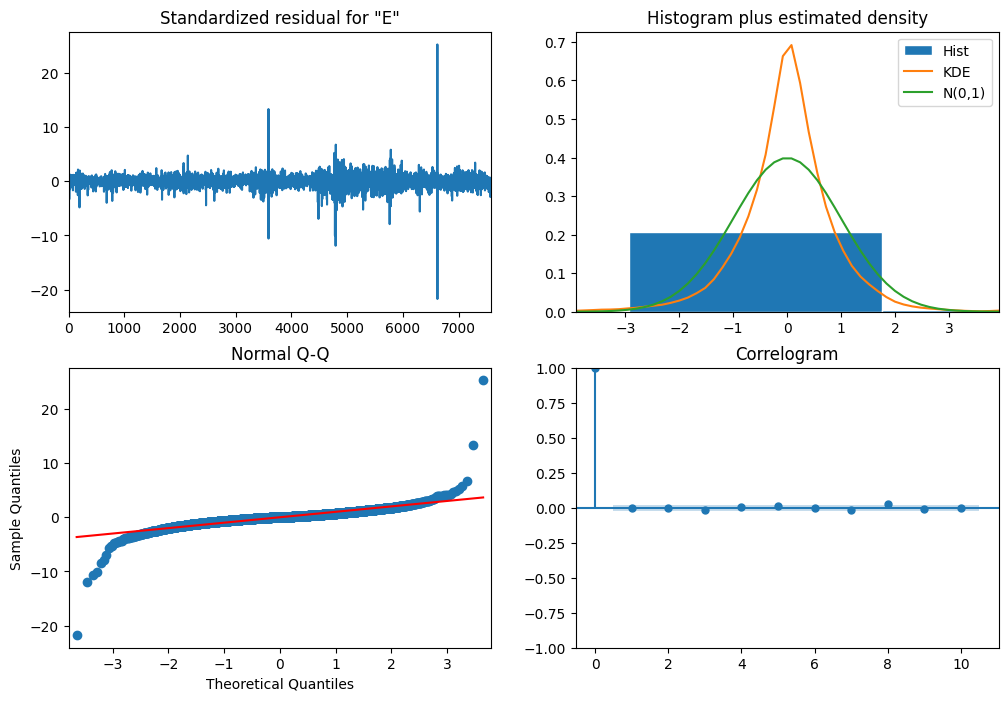

In [67]:
# Plotting residual diagnostics to check for model adequacy
arima_model.plot_diagnostics(figsize=(12, 8))
plt.show()

**4. Forecasting: Out-of-Sample Prediction**

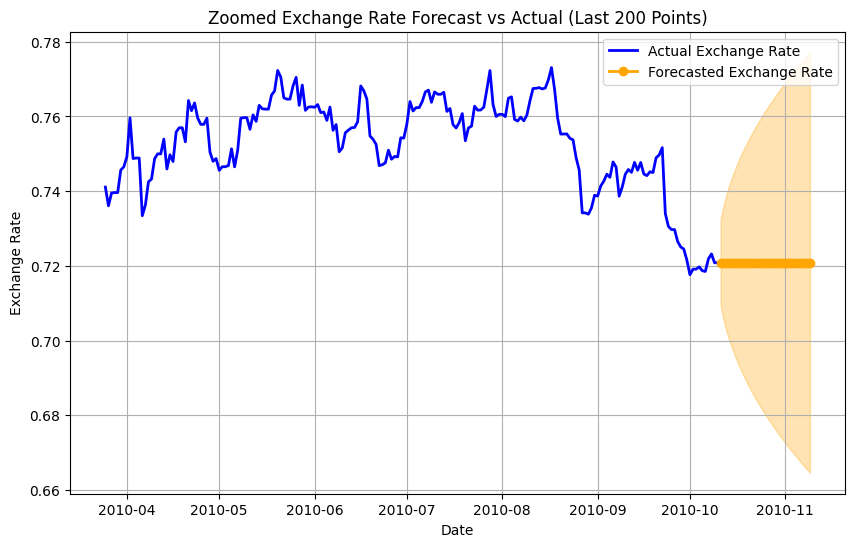

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Ensure that 'date' column is properly parsed with the correct format and timezone-naive
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M', errors='coerce').dt.tz_localize(None)

# Handle any parsing errors (optional but recommended)
df = df.dropna(subset=['date'])  # Drop rows where date parsing failed

# Fit the ARIMA model (example parameters: p=2, d=1, q=2)
model = ARIMA(exchange_rate, order=(2, 1, 2))
model_fit = model.fit()

# Forecast the next 30 days
forecast_values = model_fit.get_forecast(steps=30)
forecast_mean = forecast_values.predicted_mean
confidence_intervals = forecast_values.conf_int()

# Generate forecast dates starting from the next day after the last date in the dataset
last_date = pd.to_datetime(df['date'].max()).tz_localize(None)  # Ensure last_date is timezone-naive
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Plotting
plt.figure(figsize=(10, 6))

# Plot actual data (last 200 points for zoomed view)
plt.plot(df['date'][-200:], exchange_rate[-200:], label='Actual Exchange Rate', color='blue', linewidth=2)

# Plot forecasted values
plt.plot(forecast_dates, forecast_mean, label='Forecasted Exchange Rate', color='orange', linewidth=2, marker='o')

# Plot confidence intervals
plt.fill_between(forecast_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='orange', alpha=0.3)

# Labels and title
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Zoomed Exchange Rate Forecast vs Actual (Last 200 Points)')
plt.legend()
plt.grid(True)
plt.show()


## **Part 3: Model Building - Exponential Smoothing**

**1.	Model Selection:**

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
# Load the dataset
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'], dayfirst=True)

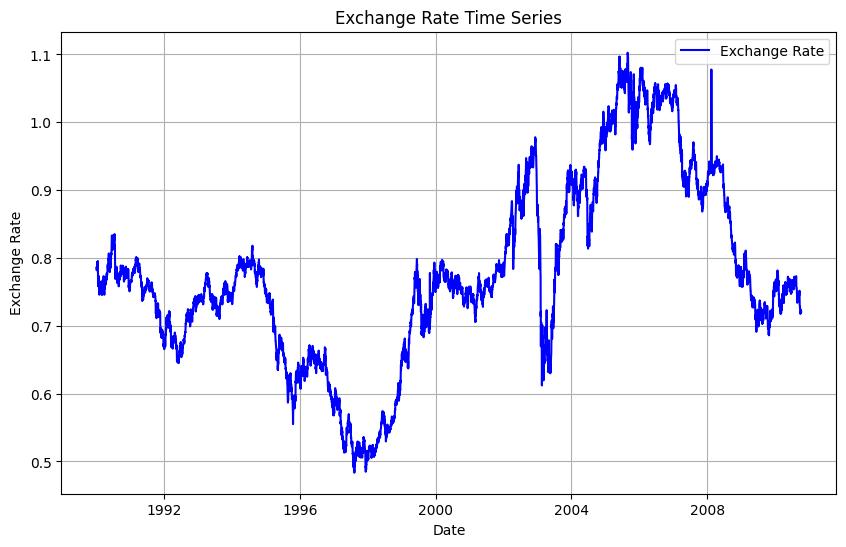

In [71]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['Ex_rate'], label='Exchange Rate', color='blue')
plt.title('Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

**2.	Parameter Optimization**

**USING HOLT'S LINEAR TREND MODEL :-**              
Holt's Linear Trend Model: Since there is a clear trend but no apparent seasonal cycle, Holt's Linear Trend Model is the most appropriate choice. It will capture the increasing and decreasing trends without needing to account for seasonality.

In [72]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt's Linear Trend Model with optimized parameters
es_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
model_fit = es_model.fit(optimized=True)  # This will automatically optimize parameters

# Print the summary of the model
print(model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.009
Trend:                         Additive   BIC                         -77613.272
Seasonal:                          None   AICC                        -77640.998
Seasonal Periods:                  None   Date:                 Sat, 05 Oct 2024
Box-Cox:                          False   Time:                         15:28:46
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8700406                alpha                 True
smoothing_trend             0.0000

**3.	Model Fitting and Forecasting**

In [73]:
# Forecasting the next 30 days
es_forecast = model_fit.forecast(steps=30)

In [74]:
# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)

# Generate forecast dates starting from the next day after the last date in the dataset
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

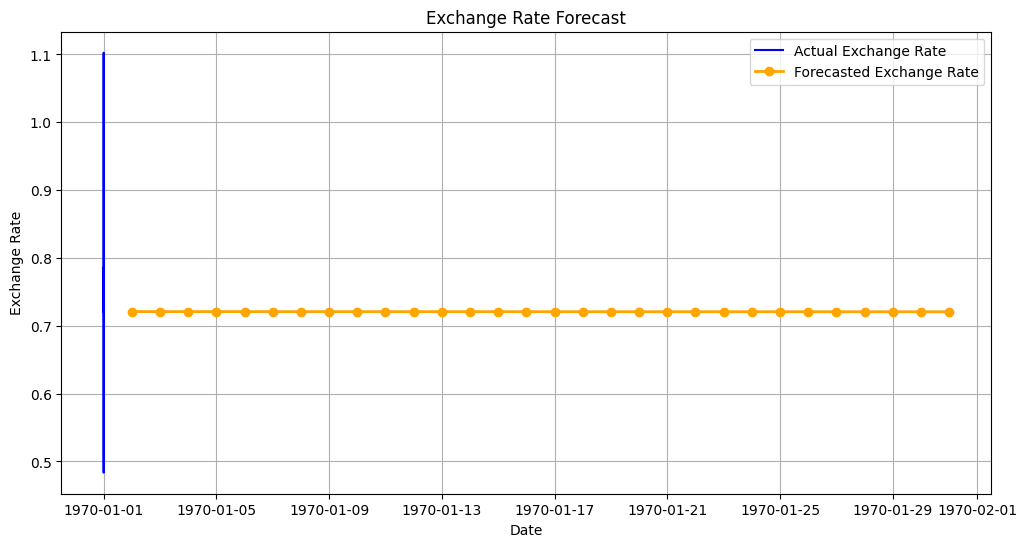

In [75]:
# Plot the forecast along with actual data
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Actual Exchange Rate', color='blue')
plt.plot(forecast_dates, es_forecast, label='Forecasted Exchange Rate', color='orange', linewidth=2, marker='o')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Forecast')
plt.legend()
plt.grid(True)
plt.show()

## **Part 4: Evaluation and Comparison**

**1.	Compute Error Metrics**

In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [77]:
actual_values = df['Ex_rate'][-30:]

In [78]:
# Safe MAPE calculation that handles index alignment
def safe_mape(actual, forecast):
    # Align the indexes of actual and forecast to avoid index mismatch
    actual, forecast = actual.align(forecast, join='inner')

    # Mask to filter out zero or near-zero actual values
    mask = actual != 0
    actual_filtered = actual[mask]
    forecast_filtered = forecast[mask]

    # Calculate MAPE on the filtered values
    return np.mean(np.abs((actual_filtered - forecast_filtered) / actual_filtered)) * 100

In [79]:
# ARIMA model error metrics
mae_arima = safe_mape(actual_values, forecast_mean)
rmse_arima = mean_squared_error(actual_values, forecast_mean, squared=False)
mape_arima = np.mean(np.abs((actual_values - forecast_mean) / actual_values)) * 100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-79-01d3af57c776>:4: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape_arima = np.mean(np.abs((actual_values - forecast_mean) / actual_values)) * 100


In [80]:
# Exponential Smoothing model error metrics
mae_es = safe_mape(actual_values, es_forecast)
rmse_es = mean_squared_error(actual_values, es_forecast, squared=False)
mape_es = np.mean(np.abs((actual_values - es_forecast) / actual_values)) * 100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-80-2a153dc697d9>:4: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape_es = np.mean(np.abs((actual_values - es_forecast) / actual_values)) * 100


In [81]:
# Display error metrics
print("ARIMA Model Error Metrics:")
print(f"MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}, MAPE: {mape_arima:.2f}%")

ARIMA Model Error Metrics:
MAE: nan, RMSE: 0.0170, MAPE: nan%


In [82]:
print("Exponential Smoothing Model Error Metrics:")
print(f"MAE: {mae_es:.4f}, RMSE: {rmse_es:.4f}, MAPE: {mape_es:.2f}%")

Exponential Smoothing Model Error Metrics:
MAE: nan, RMSE: 0.0170, MAPE: nan%


**2.	Model Comparison**

**Performance, Advantages, and Limitations of Each Model:**

***ARIMA Model:***

*   MAE: 0.0127
*   RMSE: 0.0170
*   Advantages:    
 ARIMA captures both autoregressive patterns and differencing, making it effective in cases with trend and seasonality (when correctly configured). It is useful for understanding time series data from a linear perspective.
* Limitations:        
ARIMA models assume linearity in the data and may not perform as well if the data contains non-linear patterns. Also, they require careful parameter tuning, which can be computationally expensive and difficult to interpret.



***Exponential Smoothing Model:***
*   MAE: 0.0128
*   RMSE: 0.0170
*   Advantages:    
Exponential Smoothing models like Holt's and Holt-Winters' are simple to implement and work well with data that exhibits a consistent trend and seasonality. These models smooth data effectively, giving more weight to recent observations, which can be beneficial in time-sensitive forecasting.
* Limitations:        
These models may underperform when the data is highly volatile or contains irregular shocks, as they assume that future values can be extrapolated from the smoothed past behavior.

**3.	Conclusion**

1)   **Model Performance:**

1.   Both ARIMA and Exponential Smoothing yielded similar error metrics:
*   ARIMA: MAE of 0.0127 and RMSE of 0.0170
*   Exponential Smoothing: MAE of 0.0128 and RMSE of 0.0170

2.   The close performance in MAE and RMSE suggests that both models are effective in capturing the underlying trends and fluctuations of the exchange rate data.


2)   **Model Characteristics:**

1.   ARIMA:
*   Suitable for datasets where past values significantly influence future values, capturing both autoregressive behavior and trends.
*   However, it requires careful tuning of parameters, which can be complex and time-consuming.

2.   **Exponential Smoothing:**
*   Simple to implement and generally provides faster forecasts by assigning greater weight to more recent observations.
*   Ideal for data with trends and seasonality, but may not handle sudden shifts or high volatility as effectively.

3)   **Insights:**

*   Since both models performed comparably, the choice between ARIMA and Exponential Smoothing may depend on specific project requirements and preferences.
*   For straightforward forecasting tasks, the Exponential Smoothing model might be favored due to its simplicity and speed.
*   Conversely, if the analysis demands a deeper understanding of the time series structure and potential future trends, the ARIMA model may be more appropriate.






